<a href="https://colab.research.google.com/github/yeonee21/wiset/blob/main/yeoneui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

%ls

Mounted at /content/gdrive
gdrive/  sample_data/


In [ ]:
%cd gdrive/MyDrive/WISET/CTdata/

/content/gdrive/.shortcut-targets-by-id/1sB94h0sAduKeY-hI07CG62N6awnEfPLD/WISET/CTdata


In [ ]:
#!unzip CT_NonCOVID.zip
#!unzip CT_COVID.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.autograd import Variable

import cv2
import os
import math

from sklearn.model_selection import train_test_split



In [ ]:
%ls

CT_COVID.zip  CT_NonCOVID.zip  Data-split/          __MACOSX/
CTData/       CT_resnet50.pt   JCS_COVID-19-CT100/  Splitted/


In [ ]:
# Image transforms
resnet_trans = { 
    'train': transforms.Compose([
                            transforms.Resize([64,64]),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
                            transforms.Resize([64,64]),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],
                                                 [0.229, 0.224, 0.225])])
}


In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 32
EPOCH =30



1. data 분할을 위한 폴더 생성(train, val, test)
2. 생성한 train,val,test 폴더에 비율에 맞게 이미지를 복사해서 저장

In [ ]:
import shutil

original_data_dir = '/content/gdrive/MyDrive/WISET/CTdata/CTData'
classes = os.listdir(original_data_dir)

base_dir = '/content/gdrive/MyDrive/WISET/CTdata/Splitted'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

for c in classes:
  os.mkdir(os.path.join(train_dir, c))
  os.mkdir(os.path.join(val_dir, c))
  os.mkdir(os.path.join(test_dir, c))


# data 분할 train:val:test = 0.6: 0.2: 0.2
for c in classes:
  path = os.path.join(original_data_dir, c)
  files = os.listdir(path)

  train_size = math.floor(len(files)*0.6)
  val_size = math.floor(len(files)*0.2)
  test_size = math.floor(len(files)*0.2)

  train_file = files[:train_size]
  print('Train size(',c,'):', len(train_file))
  # Train data를 새로운 파일 'train'에 복사해서 저장
  # src 경로의 파일을 dst 경로의 파일에 저장
  for fname in train_file:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(train_dir, c), fname)
    shutil.copyfile(src, dst)
  
  val_file = files[train_size:(val_size + train_size)]
  print('Validation size(',c,'):', len(val_file))
  # Validation data를 새로운 파일'val'에 복사해서 저장
  for fname in val_file:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(val_dir, c), fname)
    shutil.copyfile(src, dst)
  
  test_file = files[(train_size + val_size):(val_size + train_size + test_size)]
  print('Test size(',c,'):', len(test_file))
  # Test data를 새로운 파일'test'에 복사해서 저장
  for fname in test_file:
    src = os.path.join(path, fname)
    dst = os.path.join(os.path.join(test_dir, c), fname)
    shutil.copyfile(src, dst)



Train size( CT_NonCOVID ): 238
Validation size( CT_NonCOVID ): 79
Test size( CT_NonCOVID ): 79
Train size( CT_COVID ): 210
Validation size( CT_COVID ): 70
Test size( CT_COVID ): 70


In [ ]:
data_dir = '/content/gdrive/MyDrive/WISET/CTdata/Splitted'
mode = os.listdir(data_dir)

for m in mode:
  path1 = os.path.join(data_dir, m)
  classes = os.listdir(path1)
  for c in classes:
    path2 = os.path.join(path1, c)
    files = os.listdir(path2)
    print(m, 'data size(', c, '): ',len(files))

train data size( CT_NonCOVID ):  238
train data size( CT_COVID ):  210
val data size( CT_NonCOVID ):  79
val data size( CT_COVID ):  70
test data size( CT_NonCOVID ):  79
test data size( CT_COVID ):  70


# 데이터 불러오기

In [ ]:
# Create training and validation datasets
image_datasets = {x: ImageFolder(os.path.join(base_dir, x), transform = resnet_trans[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print('Datasize:', dataset_sizes)
print('Class: ', class_names)

Datasize: {'train': 448, 'val': 597}
Class:  ['CT_COVID', 'CT_NonCOVID']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Pre-Trained Model 불러오기

CTdata -> 작은 데이터셋, pre-trained model의 데이터셋과 상이
따라서 일부 레이어만 훈련시키는 finetuning

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

# 7 epoch마다 0.1씩 곱해서 lr을 감소시킨다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Pre-trained model 일부 layer freeze
# Resnet의 10개 layer 중 5번째까지 고정하고 6~10 layer의 parameter는 update
ct = 0
for child in resnet.children():
  ct +=1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:

class RESNET50(nn.Module):
  def __init__(self):
    super(RESNET50, self).__init__()
        
    # get the pretrained resnet50 network
    self.resnet = models.resnet50(pretrained=True)
    
    # disect the network to access its last convolutional layer
    self.features_conv = self.resnet.features[:6]
        
    # get the max pool of the features stem
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
    # get the classifier of the resnet
    self.classifier = self.resnet.classifier
        
    # placeholder for the gradients
    self.gradients = None
    
  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad
        
  def forward(self, x):
    x = self.features_conv(x)
        
    # register the hook
    h = x.register_hook(self.activations_hook)
        
    # apply the remaining pooling
    x = self.max_pool(x)
    x = x.view((1, -1))
    x = self.classifier(x)
    return x
    
  # method for the gradient extraction
  def get_activations_gradient(self):
    return self.gradients
    
  # method for the activation exctraction
  def get_activations(self, x):
    return self.features_conv(x)



In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in resnet.state_dict():
    print(param_tensor, "\t", resnet.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer_ft.state_dict():
    print(var_name, "\t", optimizer_ft.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

In [ ]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler ,num_epochs=25):
    since = time.time()

    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('===========================================================')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  _, preds = torch.max(outputs, 1)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
              scheduler.step()
              l_r = [x['lr'] for x in optimizer_ft.param_groups]
              print('learning rate: ', l_r)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =='train':
              loss_history.append(epoch_loss)
              acc_history.append(epoch_acc)

            if phase == 'val':
              val_loss_history.append(epoch_loss)
              val_acc_history.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, val_loss_history, acc_history, val_acc_history


# Run Training and Validation Step

In [ ]:
# Train
model_resnet50, loss_hist, val_loss_his, acc_hist, val_acc_hist = train_model(resnet, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

torch.save(model_resnet50, 'CT_resnet50.pt')

Epoch 0/29


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


learning rate:  [0.001]
train Loss: 1.0632 Acc: 0.5714
val Loss: 1.7684 Acc: 0.5796

Epoch 1/29
learning rate:  [0.001]
train Loss: 0.5766 Acc: 0.7121
val Loss: 7.1410 Acc: 0.7353

Epoch 2/29
learning rate:  [0.001]
train Loss: 0.5820 Acc: 0.7478
val Loss: 0.8382 Acc: 0.7370

Epoch 3/29
learning rate:  [0.001]
train Loss: 0.4425 Acc: 0.8036
val Loss: 0.5015 Acc: 0.8023

Epoch 4/29
learning rate:  [0.001]
train Loss: 0.3709 Acc: 0.8549
val Loss: 0.3687 Acc: 0.8459

Epoch 5/29
learning rate:  [0.001]
train Loss: 0.2852 Acc: 0.8906
val Loss: 0.2985 Acc: 0.8827

Epoch 6/29
learning rate:  [0.0001]
train Loss: 0.3447 Acc: 0.8281
val Loss: 0.3923 Acc: 0.8425

Epoch 7/29
learning rate:  [0.0001]
train Loss: 0.2565 Acc: 0.8884
val Loss: 0.3068 Acc: 0.8693

Epoch 8/29
learning rate:  [0.0001]
train Loss: 0.2024 Acc: 0.9330
val Loss: 0.2792 Acc: 0.8878

Epoch 9/29
learning rate:  [0.0001]
train Loss: 0.2071 Acc: 0.9286
val Loss: 0.2666 Acc: 0.9028

Epoch 10/29
learning rate:  [0.0001]
train Loss

In [ ]:
print(loss_hist)

[1.063152402639389, 0.5765546560287476, 0.5820353350469044, 0.4424759362425123, 0.37086410926921026, 0.2851668468543461, 0.34469409340194296, 0.2564744587455477, 0.20240259915590286, 0.20714327480111802, 0.14808550955993788, 0.10167584115905422, 0.10985622022833143, 0.09174754470586777, 0.07438418881169387, 0.06768159508439046, 0.10165064249719892, 0.06618278633270945, 0.07763611232595784, 0.0675206407904625, 0.06793915240892343, 0.08424357138574123, 0.0642445416056684, 0.09508785831608943, 0.05625110532024077, 0.06339883944019675, 0.05427566037646362, 0.04228510880576713, 0.0804724231628435, 0.062231547598327906]


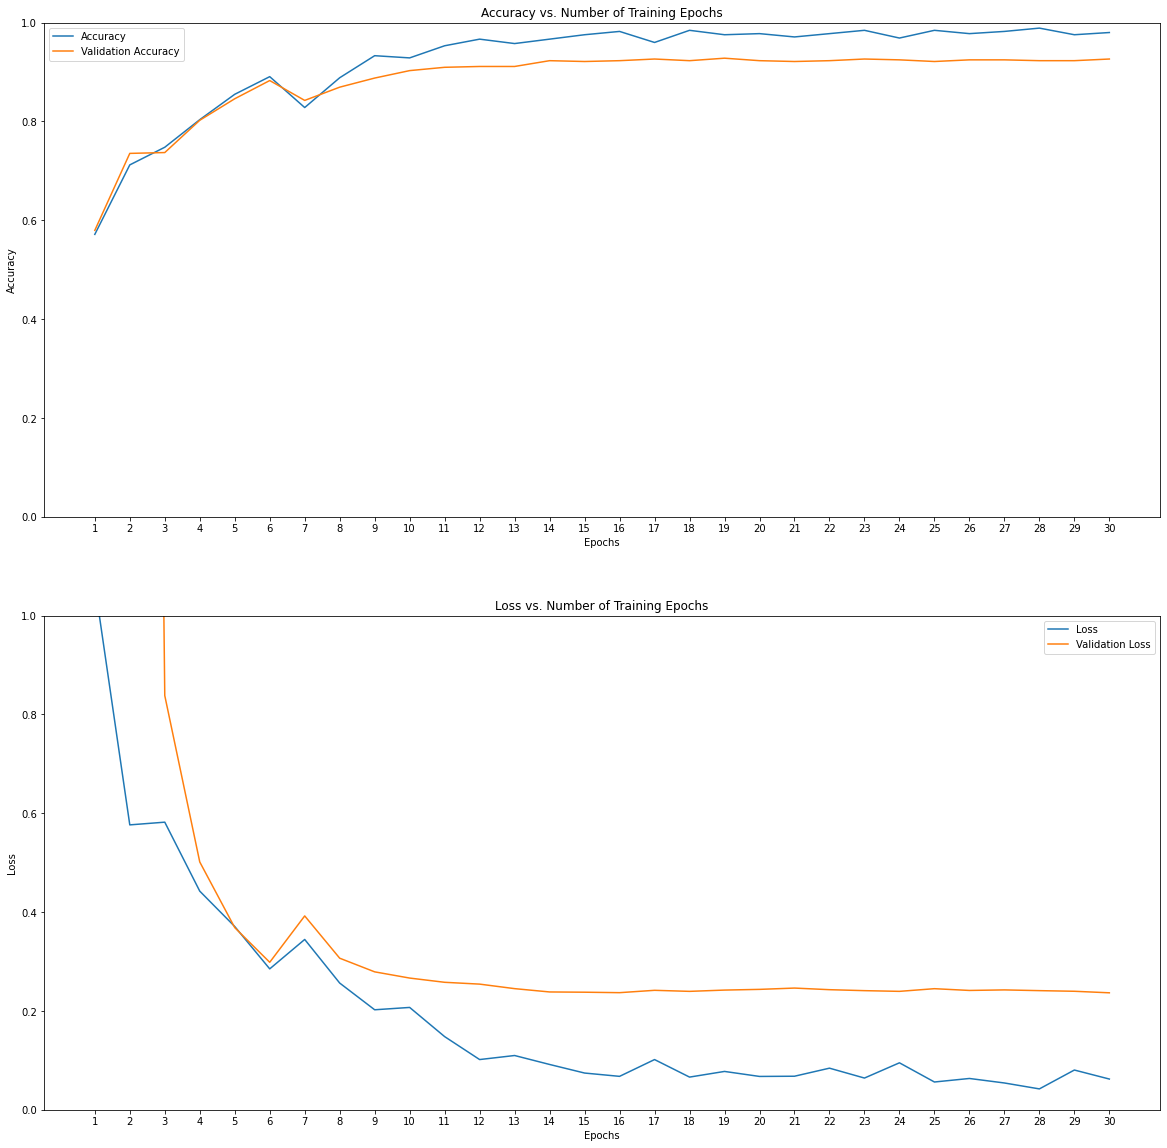

In [ ]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
'''
resnet_loss_hist = []
resnet_val_loss_hist = []
resnet_acc_hist = []
resnet_val_acc_hist = []

resnet_loss_hist = [h.cpu().numpy() for h in loss_hist]
resnet_val_loss_hist = [h.cpu().numpy() for h in val_loss_hist]
resnet_acc_hist = [h.cpu().numpy() for h in acc_hist]
resnet_val_acc_hist = [h.cpu().numpy() for h in val_acc_hist]
'''
plt.figure(figsize=[20,20])
plt.subplot(2, 1, 1)
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,EPOCH+1),acc_hist,label="Accuracy")
plt.plot(range(1,EPOCH+1),val_acc_hist,label="Validation Accuracy")
plt.ylim((0,1.))
plt.xticks(np.arange(1, EPOCH+1, 1.0))
plt.legend()

plt.subplot(2, 1, 2)  
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,EPOCH+1),loss_hist,label="Loss")
plt.plot(range(1,EPOCH+1),val_loss_his,label="Validation Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, EPOCH+1, 1.0))
plt.legend()

plt.show()


# Evaluation

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  # 평가 단계에서는 parameter update 중단
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)

      # output(예측값)과 target 사이의 loss 계산
      test_loss += F.cross_entropy(output, target, reduction='sum').item()

      # 가장 높은 확률값을 가진 인덱스를 pred로 저장
      pred = output.max(1, keepdim=True)[1]
      # pred와 target이 일치하면 1, 일치하지 않으면 0을 반환. (view_as()를 통해 pred, target tensor를 같은 모양으로 정렬)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)

  return test_loss, test_accuracy


In [ ]:

testset = ImageFolder(root= '/content/gdrive/MyDrive/WISET/CTdata/Splitted/test', transform = resnet_trans['val'])
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

resnet50 = torch.load('CT_resnet50.pt')
resnet50.eval()
test_loss, test_accuracy = evaluate(resnet50, test_dataloader)

print('test acc: ', test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test acc:  93.28859060402685


In [ ]:
import skimage

for batch_index, (data, target) in enumerate(dataloaders_dict['train']):
  img = data.numpy()

print(img.shape)
plt.figure(figsize=(500,500))
skimage.io.imshow(img[0,1,:,:])
#for i in range(9):
#  skimage.io.imshow(img[i,1,:,:])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(32, 3, 64, 64)


In [ ]:


i = 0
for batch_idx, (inputs, targets) in enumerate(dataloaders_dict['train']): 
    img = inputs / 2 +0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(100,100))
    plt.subplot(14,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(npimg[i], (1, 2, 0)), cmap=plt.cm.gray)
    # labels
    plt.title(' '.join('%6s' % class_names[targets[i]] ))
    i = i+1


plt.show()










NameError: ignored